# Demonstration of deconvolving PAX data
For details, see the manuscript

In [1]:
# Install pax_deconvolve
#!pip install git+https://github.com/dhigley6/PAX2

In [2]:
# import standard python modules:
import numpy as np 
%matplotlib inline
%load_ext tensorboard

# import custom python modules:
from pax_deconvolve.pax_simulations import simulate_pax
from pax_deconvolve.deconvolution import deconvolvers, assess_convergence
from pax_deconvolve import visualize

# set simulation parameters
LOG10_NUM_ELECTRONS = 5.0  # 10^7 detected electrons (over entire dateset)
RIXS_MODEL = 'schlappa'  # use RIXS model chosen to approximate that in Schlappa's paper
PHOTOEMISSION_MODEL = 'ag'   # use Ag 3d core levels as model photoemission
NUM_SIMULATIONS = 100    # Number of PAX spectra to simulate
ENERGY_LOSS = np.arange(-8, 10, 0.01)  # energy loss values of RIXS to simulate over
REGULARIZATION_STRENGTHS = np.logspace(-3, -1, 10)  # Regularization strengths to try
ITERATIONS = 100    # Number of iterations to run simulations for
CV_FOLD = 3   # Number of folds to use for cross validation

In [3]:
# Simulate some PAX data 
impulse_response, pax_spectra, xray_xy = simulate_pax.simulate_from_presets(
    LOG10_NUM_ELECTRONS,
    RIXS_MODEL,
    PHOTOEMISSION_MODEL,
    NUM_SIMULATIONS,
    ENERGY_LOSS
)

In [4]:
# Assess convergence of PAX data

# Run convergence assessment
assess_convergence.run(
    impulse_response['x'],
    impulse_response['y'],
    pax_spectra['x'],
    pax_spectra['y'],
    REGULARIZATION_STRENGTHS,
    ITERATIONS
)

# Show data which can be used to assess convergence (see manuscript):
%tensorboard --logdir logdir
# Since this is simulated data, the deconvolved mean squared error is also shown,
# but that would usually not be accessible since the ground truth is usually
# unknown

ERROR: Failed to launch TensorBoard (exited with -6).
Contents of stderr:
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/descriptor_database.cc:393] Invalid file descriptor data passed to EncodedDescriptorDatabase::Add().
[libprotobuf FATAL external/com_google_protobuf/src/google/protobuf/descriptor.cc:1367] CHECK failed: GeneratedDatabase()->Add(encoded_file_descriptor, size): 
libc++abi.dylib: terminating with uncaught exception of type google::protobuf::FatalException: CHECK failed: GeneratedDatabase()->Add(encoded_file_descriptor, size):

In [5]:
#  Deconvolve PAX data, determining regulariation strength by cross validation of how well
#  we can estimate unseen data from the deconvolved result

# Run deconvolution
deconvolver = deconvolvers.LRFisterGrid(
        impulse_response['x'],
        impulse_response['y'],
        pax_spectra['x'],
        REGULARIZATION_STRENGTHS,
        ITERATIONS,
        xray_xy['y'],
        CV_FOLD
)
_ = deconvolver.fit(np.array(pax_spectra['y']))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.0s finished
/Users/dhigley/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


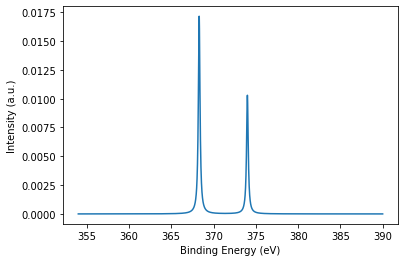

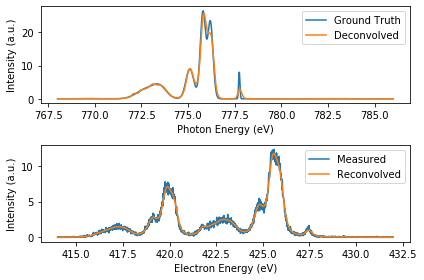

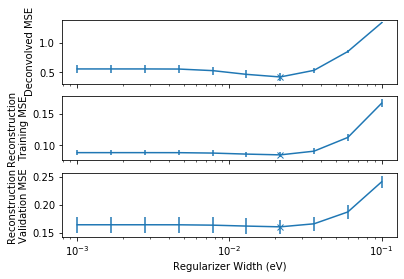

In [6]:
# Plot results
visualize.plot_photoemission(deconvolver)
visualize.plot_result(deconvolver)
visualize.plot_cv(deconvolver)